<a href="https://colab.research.google.com/github/Mingyuli1996/Stock-Price-Estimation/blob/master/Stock_price_multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Import all the needed packages

!pip install pykalman

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
from datetime import datetime, timedelta
from pykalman import KalmanFilter
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import keras.layers as kl
from keras.models import Model
from keras import regularizers
%matplotlib inline

Using TensorFlow backend.


In [0]:
### define functions used below

def reduce_noise(X):
    index1=X.index.values
    name1=X.name
#This function applys kalman filter to reduce the noise in daily stock price
    kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = X.values[0],
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)
    
    state_means,_ = kf.filter(X.values)
    state_means = state_means.flatten()
    state_means=pd.DataFrame(data=state_means, index = index1, columns=[name1])
#     state_means=state_means.astype(int) 
    return state_means

def get_prices(ticks, st, ed):
# This function gets Adjusted Closing prices from Yahoo Finance
# returns a DataFrame. Inputs are ticks (list of tickers), st (start date), ed (end date)
    for idx, ticker in enumerate(ticks):
        print(ticker)
        f = web.DataReader(ticker, 'yahoo', st, ed)['Adj Close']
        f.name = ticker
        if idx==0:
            df = f
        else:
            df = pd.concat([df, f], axis=1)
        return df


def denoise(data):
# This function denoise the whole dataset
    ticks=list(data.columns)
    for i  ,ticker in enumerate(ticks):
        print(ticker)
        f_clean=reduce_noise(data[ticker])
#         f_clean=pd.DataFrame(data=f_clean,index = data.index.values,columns=[ticker])
        if i ==0:
            data_clean=f_clean
        else:
            data_clean = pd.concat([data_clean, f_clean], axis=1)
    return data_clean

In [0]:
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [0]:
#set lagging period
lagging=1

In [5]:
#get the data
start = dt.datetime(2009, 5, 1)
end   = dt.datetime(2019,5,1)

#trianing data
tickers_train = [['IBM','SPY','^TNX']]
df_train= get_prices(tickers_train, start, end)
print(df_train.shape)

['IBM', 'SPY', '^TNX']
(2517, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [0]:
#check the missing value in the training dataset
df_train=df_train.dropna(axis=0)
df_train.isnull().sum()
df_test=df_train[['IBM']]

In [0]:
#adjust the risk free rate price
df_train[['^TNX']]=(df_train[['^TNX']]+1)**(2.71828)

In [8]:
#Denoise the dataset
df_clean=denoise(df_train)
# df_clean=df

IBM
SPY
^TNX


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


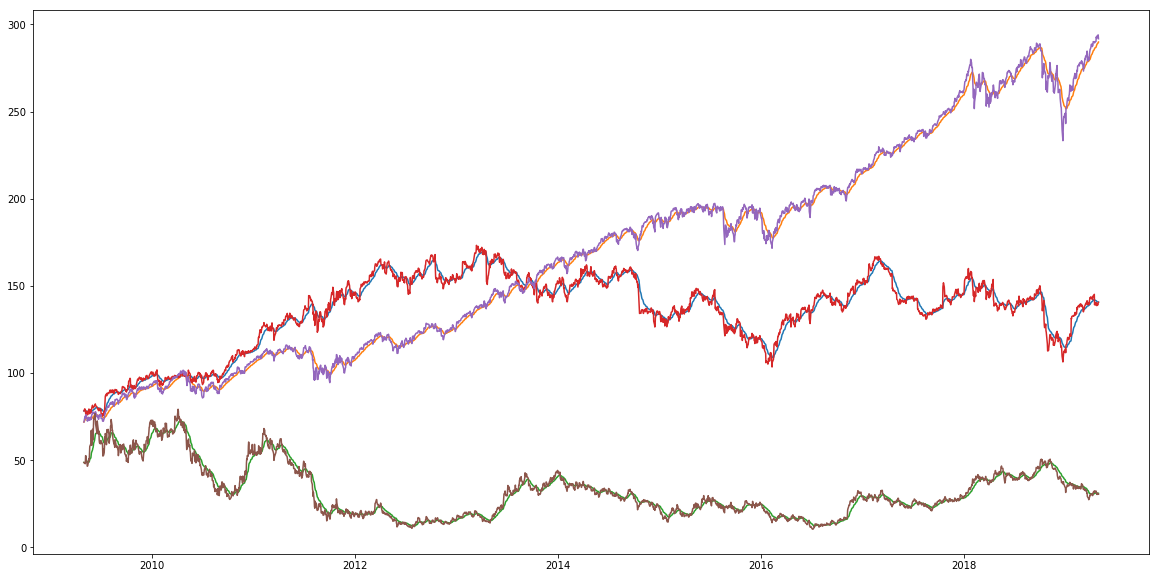

In [9]:
#plot the data
plt.plot(df_clean)
plt.plot(df_train)

# plt.xlabel("Dates")
# plt.ylabel("Stock Prices")
# plt.title('Price Trend from 2009 to 2019')



# ax = predictions_df.rename(columns={"IBM": "predicted_price"}).plot(title='Price Trend from 2009 to 2019')
# ax.set_xlabel("Dates")
# ax.set_ylabel("Stock Prices")
# fig = y_test.rename(columns={"prices": "actual_price"}).plot(ax = ax).get_figure()

In [10]:
#set the training and testing period
train_start_date = '2009-05-01'
train_end_date = '2017-04-30'
test_start_date = '2017-05-01'
test_end_date = '2019-05-01'

#creating train and test sets
train = df_train.ix[train_start_date : train_end_date]
test= df_test.ix[test_start_date:test_end_date]
print(train.shape,test.shape)

(2011, 3) (504, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [0]:
clean_dataset = df_clean.values
dataset = df_test.values

#converting dataset into X_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_clean = scaler.fit_transform(clean_dataset)
scaled_data = scaler.fit_transform(dataset)

In [12]:
cov_mat = np.cov(scaled_data_clean.T) # careful here need to transpose "X" 
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenValues \n%s' % eigen_vals)


EigenValues 
[0.12130885 0.01866083 0.05479343]


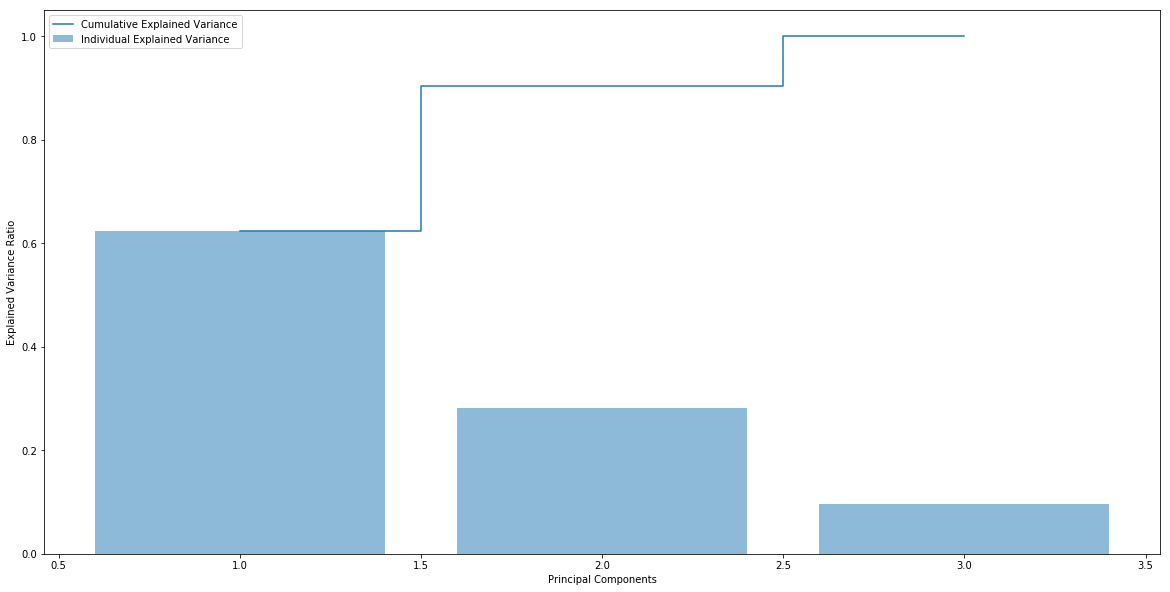

In [13]:
tot = sum(eigen_vals)

var_exp = [(i/tot) for i in sorted(eigen_vals, reverse = True)]

cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1,len(var_exp)+1), var_exp, alpha = 0.5, align = 'center',
        label = 'Individual Explained Variance')
plt.step(range(1,len(var_exp)+1), cum_var_exp, where='mid',
        label = 'Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')

plt.show()

In [0]:
len_train=len(train)
X_train = []
y_train = []
for i in range(60,len_train):
    X_train.append(scaled_data_clean[i-60:i,:])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
# X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [0]:
# input_data = kl.Input(shape=(X_train.shape[1],1))
# lstm = kl.LSTM(5, input_shape=(X_train.shape[1],1), return_sequences=True, activity_regularizer=regularizers.l2(0.003),
#                        recurrent_regularizer=regularizers.l2(0), dropout=0.2, recurrent_dropout=0.2)(input_data)
# perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(0.005))(lstm)
# lstm2 = kl.LSTM(2, activity_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.001),
#                         dropout=0.2, recurrent_dropout=0.2)(perc)
# out = kl.Dense(1, activation="sigmoid", activity_regularizer=regularizers.l2(0.001))(lstm2)

# model = Model(input_data, out)
# model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])

In [0]:
# # Initialising the RNN
# model= Sequential()

# # Adding the first LSTM layer and some Dropout regularisation
# model.add(LSTM(units=50,return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
# model.add(Dropout(0.2))

# # Adding a second LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# # Adding a third LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# # Adding a fourth LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50))
# model.add(Dropout(0.2))

# # Adding the output layer
# model.add(Dense(units = 1))

# # Compiling the RNN
# model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# # Fitting the RNN to the Training set
# model.fit(X_train, y_train, epochs = 100, batch_size = 64,verbose=1)

In [17]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50,return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1951/1951 [==============================] - 6s 3ms/step - loss: 0.0433 - mean_squared_error: 0.0433
Epoch 2/100
1951/1951 [==============================] - 5s 2ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 3/100
1951/1951 [==============================] - 5s 2ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 4/100
1951/1951 [==============================] - 5s 2ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 5/100
1951/1951 [==============================] - 5s 2ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 6/100
1951/1951 [==============================] - 5s 2ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 7/100
1951/1951 [==============================] - 5s 2ms/step - loss: 0.0052 - m

In [18]:
len_test=len(test)
len_total=len(scaled_data_clean)
len_test_lagging=len_total-lagging



X_test = []
for i in range(len_train, len_total):
    X_test.append(scaled_data_clean[i-60:i, :])


X_test= np.array(X_test)
    
y_test=dataset[len_train:,0]
print(X_test.shape , y_test.shape)

# X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

(504, 60, 3) (504,)


In [0]:
# dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
# inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
# inputs = inputs.reshape(-1,1)
# inputs = sc.transform(inputs)
# X_test = []
# for i in range(60, 80):
#     X_test.append(inputs[i-60:i, 0])
# X_test = np.array(X_test)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [0]:
closing_price = model.predict(X_test)
adj_test=np.concatenate((closing_price,scaled_data_clean[len_train:,1:]),axis=1)
adj_test=scaler.inverse_transform(adj_test)
closing_price =adj_test[:,0]

In [21]:
rms=np.sqrt(np.mean(np.power((y_test-closing_price),2)))
rms

4.1833192968121935

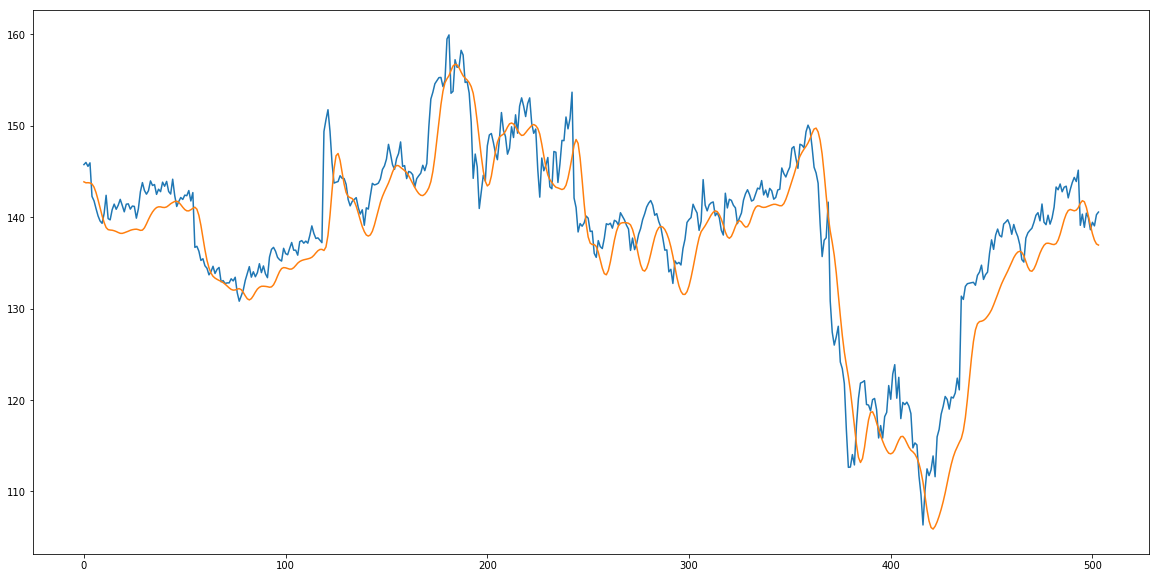

In [22]:
plt.plot(y_test)
plt.plot(closing_price)

In [23]:
#set initial fund amount
fund=1000000
holding=0
portfolio=fund+holding


# #long the stock when perdiction price>real price
# #short the stock when perdiction price <real price
# for i in range(1,len_test):
#     if y_test[i-1]>=closing_price[i-1] and y_test[i]<=closing_price[i]:
#         holding=

SyntaxError: ignored